# Master-Part Relationships


Master-part relationships capture the idea that a single *master* entity owns a collection of tightly-coupled *parts*. Each part row exists only in the context of its master row and is populated, updated, and deleted together with the master. This pattern is common when a logical record naturally expands into several subordinate records (e.g., an order header with multiple order lines, a scan with several channels, or a model fit with parameter sets).


## How DataJoint models master-part entities

DataJoint provides first-class syntax for master-part relationships:

1. **Nested class definition** – Parts are declared as nested classes inside their master class. The master is a normal table declaration (usually `dj.Manual` or `dj.Computed`), while each part inherits from `dj.Part`.
2. **Implicit foreign key** – Because the part class lives inside the master, it automatically receives a foreign key to the master. When referencing the master explicitly you can write `-> master`. When the part is declared, the columns above the separator (`---`) extend the master’s primary key, while the attributes below the separator describe the per-part fields.
3. **Diagram notation** – In schema diagrams, part tables are rendered without colored blocks. They appear as labels attached to the master node, emphasizing that they do not stand on their own. The absence of color also highlights that other tables rarely reference parts directly; the master represents the entity identity.


The snippet below assumes a `Session` table already exists and demonstrates how a master table nests its parts.


### Example structure


## Example: Computed master with part table

The remainder of this notebook demonstrates a small image-analysis workflow. The computed table `Detection` is the **master** and holds aggregate information about each detection run. Its nested part table `Detection.Blob` stores one row per detected blob. Because the part is populated inside the master’s `make()` method, every populate job produces a master/part bundle in a single transaction:

1. Fetch required inputs (the source image and a parameter set).
2. Insert the master row with summary statistics.
3. Insert all associated part rows.

If any of the inserts fail, the entire transaction is rolled back—ensuring that downstream tables never see partial results.


In [1]:
%xmode minimal

Exception reporting mode: Minimal


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import blob_doh
from skimage.color import rgb2gray

import datajoint as dj
schema = dj.Schema('image_analysis')

[2025-11-07 23:53:05,842][INFO]: DataJoint 0.14.6 connected to dev@db:3306


In [3]:
@schema
class Image(dj.Manual):
    definition = """
    image_id : int
    ---
    image_name : varchar(30)
    image : longblob
    """

Image.insert(
    (
        (1, "hubble deep field", rgb2gray(data.hubble_deep_field())),
        (2, "human mitosis", data.human_mitosis()/255.0)
    ), skip_duplicates=True
);

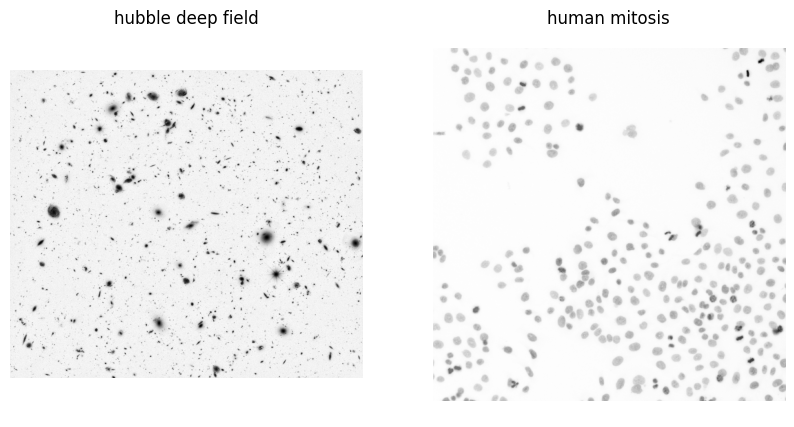

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, image, title in zip(axs, *Image.fetch("image", "image_name")):
    ax.imshow(image, cmap="gray_r")
    ax.axis('off')
    ax.axis('equal')
    ax.set_title(title)


In [5]:
@schema
class BlobParamSet(dj.Lookup):
    definition = """
    blob_paramset : int
    ---
    min_sigma : float
    max_sigma : float
    threshold : float
    """
    contents = [
        (1, 2.0, 6.0, 0.001),
        (2, 3.0, 8.0, 0.002),
        (3, 4.0, 20.0, 0.01),
    ]


@schema
class Detection(dj.Computed):
    definition = """
    -> Image
    -> BlobParamSet
    ---
    nblobs : int
    """

    class Blob(dj.Part):
        definition = """
        -> master
        blob_id : int
        ---
        x : float
        y : float
        r : float
        """

    def make(self, key):
        # fetch inputs
        img = (Image & key).fetch1("image")
        params = (BlobParamSet & key).fetch1()

        # compute results
        blobs = blob_doh(
            img, 
            min_sigma=params['min_sigma'], 
            max_sigma=params['max_sigma'], 
            threshold=params['threshold'])

        # insert master and parts
        self.insert1(dict(key, nblobs=len(blobs)))
        self.Blob.insert(
            (dict(key, blob_id=i, x=x, y=y, r=r)
             for i, (x, y, r) in enumerate(blobs)))

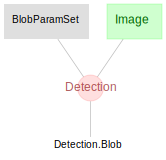

In [6]:
dj.Diagram(schema)

In [7]:
Detection.populate(display_progress=True)

{'success_count': 0, 'error_list': []}

In [8]:
Detection()

image_id,blob_paramset,nblobs
1,1,1921
1,2,971
1,3,229
2,1,364
2,2,232
2,3,11


### Why master-part matters here

`Detection` represents a single workflow step: given an image and a parameter set, compute blob detections. Each populate job produces one `Detection` tuple and a variable number of `Detection.Blob` tuples. By keeping the part table nested:

- **Atomic results** – the master row and all blob rows appear (or disappear) together.
- **Clean dependencies** – downstream analyses only reference `-> Detection`; they inherit the complete primary key and do not worry about whether blob rows were fully inserted.
- **Compact diagrams** – in the schema diagram, the master is the colored node that participates in the global workflow DAG, while the part appears as an uncolored label attached to it, signalling that it is not an independent entity.

This pattern scales to more complex pipelines—for instance, storing per-channel waveforms, per-unit spike times, or per-ROI segmentation masks—while preserving the workflow guarantees that DataJoint provides.


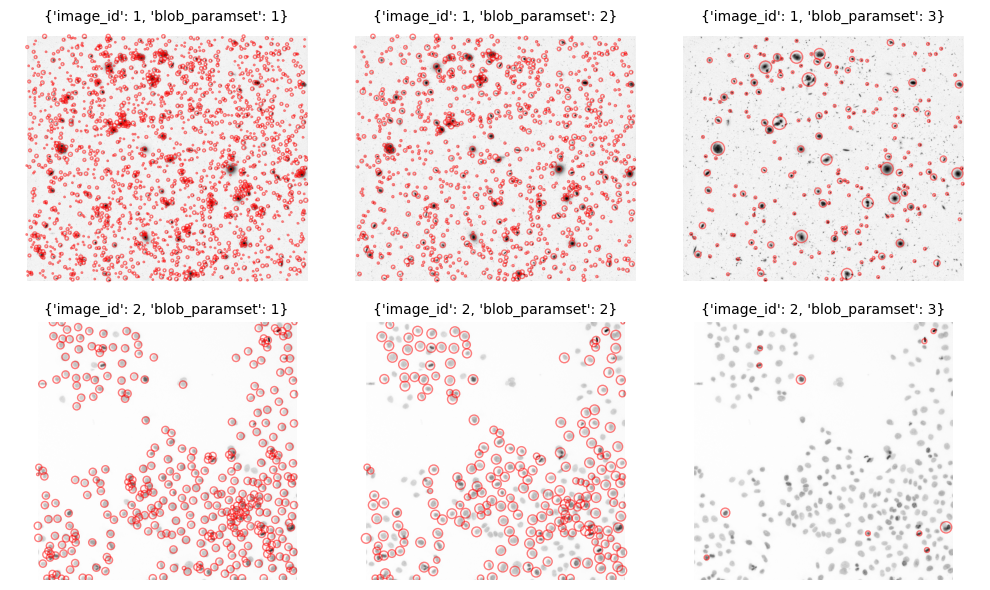

In [9]:
fix, axes = plt.subplots(2, 3, figsize=(10, 6))
for ax, key in zip(axes.ravel(), Detection.fetch("KEY", order_by="image_id, blob_paramset")):
    img = (Image & key).fetch1("image")
    ax.imshow(img, cmap="gray_r")
    ax.axis('off')
    ax.axis('equal')
    ax.set_title(str(key), fontsize=10)
    for  x, y, r in zip(*(Detection.Blob & key).fetch("y", "x", "r")):
        c = plt.Circle((x, y), r*1.2, color='r', alpha=0.5, fill=False)
        ax.add_patch(c)
plt.tight_layout()

Here `Measurement.Channel` (the part) inherits the entire primary key of `Measurement` (`Session`’s key plus any master attributes) and adds `channel_id` as an additional key attribute. Downstream tables can reference the master via `-> Measurement`, and inside the nested part we can reference the master as `-> master`.


## Workflow semantics

Master-part relationships are most powerful in auto-computed tables (`dj.Computed` or `dj.Imported`). When a master is populated, DataJoint executes the master’s `make()` method inside an atomic transaction. This guarantees that all parts belonging to the master are inserted (or updated) together with the master row. If any part fails to insert, the entire transaction is rolled back, preserving consistency.

This workflow semantics offers two key benefits:

- **Atomicity** – Every master row is all-or-nothing. Either the master and all its parts exist, or none of them do.
- **Isolation** – Parts are never left in a partially-completed state while other jobs are running. Downstream tables can safely depend on the master row, knowing that its parts are already in place.

Because master/part tables are created together, they naturally fit into the [relational workflow model](../20-concepts/04-workflows.md). The master participates in the DAG as a normal node, while the parts are executed inside the same workflow step.


## Practical guidelines

- **Use parts for tightly-coupled detail rows**: If the part data never exists without the master, implement it as a nested part rather than a separate table. Examples include waveform channels, spike units per recording, order lines for a purchase order, or parameter sweeps attached to a model fit.
- **Limit external references**: Downstream tables should almost always reference the master (`-> Measurement` in the example) rather than the part. If a downstream table truly needs to depend on a specific part, it can reference the part explicitly (`-> Measurement.Channel`), but this should be rare.
- **Keep part logic inside `make()`**: Populate the master and insert all parts from within the master’s `make()` method. Do not create separate processes that attempt to fill the part tables independently—the transactional guarantees rely on the nesting.
- **Diagram awareness**: Remember that part nodes appear without colored blocks in the diagram. Use this visual cue to distinguish between independent entity tables and parts.


## Summary

Master-part relationships provide a concise way to model a master record that owns several subordinate rows. DataJoint’s nested class syntax, automatic foreign key, and transactional populate make this pattern easy to express and safe to use. In the context of relational workflows, masters act as workflow nodes, while parts capture the detailed payload generated in the same workflow step.
